## 数据预处理

由于所使用的数据集猫狗分类是混合在一起的，没有进行分类。数据集的文件以category.no.jpg方式命名，例如dog.9999.jpg。

训练集中的命名方式也不仅仅通过递增的序号，而是以树的形式。
例如：
```
├── dog.93.jpg
├── dog.94.jpg
│   └── ...
└── dog.95.jpg
    ├── dog.951.jpg 
    └── dog.952.jpg 
        └── dog.9521.jpg
```

这里我们对文件进行预处理，将训练集分成cat和dog两个文件夹。

最终目录结构如下所示：

```
├── train2
│   └── dog
│   │   ├── dog.0.jpg 
│   │   ├── ... 
│   │   └── dog.12499.jpg 
│   └── cat
│       ├── cat.0.jpg 
│       ├── ... 
│       └── cat.12499.jpg
└── test2
    └── test
        ├── cat.1.jpg 
        ├── ...
        └── cat.12500.jpg
```

## 导入Lib库

In [20]:
import os
import cv2
import h5py
import numpy as np
from sklearn.utils import shuffle
import pandas as pd           
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint
import random
from tqdm import tqdm
%matplotlib inline   

## 数据探索

In [4]:
!echo "cats | $(find imgs/train/ -name 'cat*' | wc -l)"
!echo "dogs | $(find imgs/train/ -name 'dog*' | wc -l)"

cats | 12500
dogs | 12500


In [5]:
#显示数据
import os
import shutil

##read images names
train_filenames = os.listdir('imgs/train')
train_cat = [img for img in filter(lambda x:x[:3] == 'cat', train_filenames)]
train_dog = [img for img in filter(lambda x:x[:3] == 'dog', train_filenames)]


train_total = np.concatenate((train_cat,train_dog))

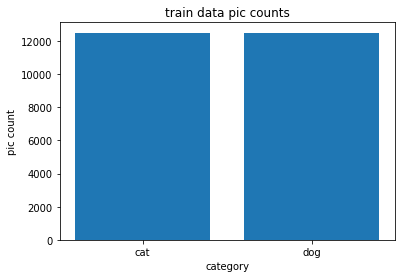

In [6]:
x =np.array([len(train_cat),len(train_dog)])
plt.bar(['cat','dog'],[x[0],x[1]])
plt.xlabel('category')
plt.ylabel('pic count')
plt.title('train data pic counts')
plt.show()

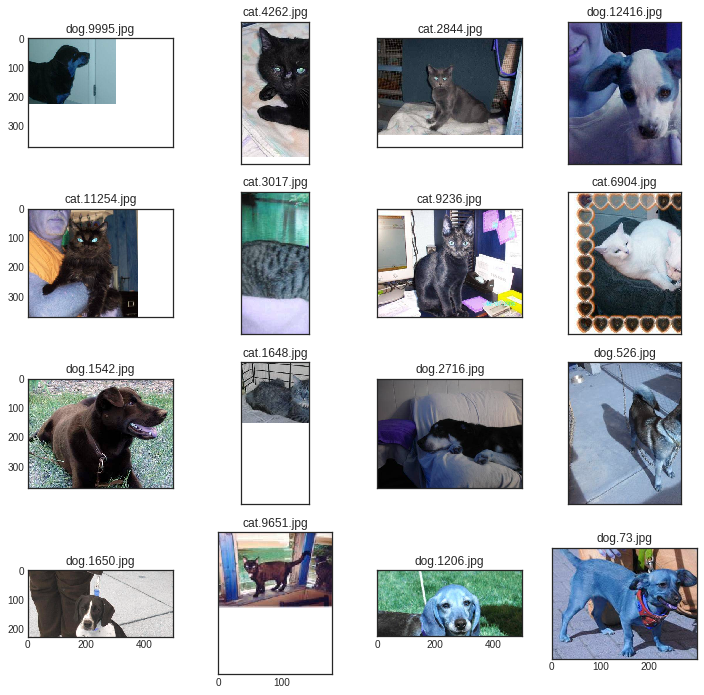

In [7]:
plt.style.use('seaborn-white')
random.seed(42)
#查看图片内容
fig,ax = plt.subplots(4,4,sharex='col',sharey='row',figsize=(12,12))

#随机获取图片
for i in range(4):
    for j in range(4):
        #随机获取图片
        ran = random.randint(0,25000)
        img = cv2.imread("imgs/train/%s" % train_total[ran])
        ax[i,j].set_title('%s'% train_total[ran])
        ax[i,j].imshow(img)

In [8]:
## 现实所有图片尺寸
type(train_total)
def get_shape(img_arr:np.ndarray)-> tuple:
    shape_list = []
    for index in img_arr:
        img = cv2.imread("imgs/train/%s" % index)
        shape_list.append([img.shape[0],img.shape[1]])
    return (shape_list)
    
shape_list = get_shape(train_total)

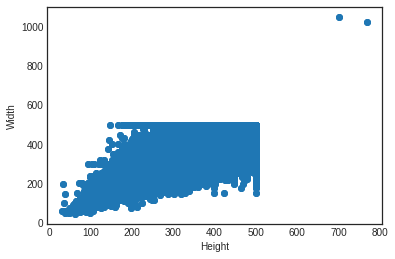

In [9]:
# 绘制散点分布图
x_index = [i[0] for i in shape_list]
y_index = [i[1] for i in shape_list]

plt.scatter(x_index,y_index)
plt.xlabel('Height')
plt.ylabel('Width')
plt.plot(x_index,y_index,'o')
plt.show()

## 采用预处理模型剔除异常数据


In [10]:
img_size = (299, 299)
## 载入预先下载好的ImageNet分类csv文件
import csv
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

def get_imageNet_class(file_path:str)->tuple:
    category_class = []
    with open(file_path,'r') as f:
        reader = csv.reader(f)
        for line in reader:
            if(line[1] == '猫') or (line[1] == '狗'):
                category_class.append(line[0])
    return (category_class)

def conv_img_path(img_arr:np.ndarray)->tuple:
    dir_path = []
    for i in train_total:
        dir_path.append('imgs/train/%s' % i)
    return (dir_path)

def read_image(img_path:str)->tuple:
    img = image.load_img('%s' % img_path,target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)
    return (x)

def read_image_dir(dir_list:list)->tuple:
    preprocess_imgs = [read_image(fp) for fp in tqdm(dir_arr)]
    return (preprocess_imgs)

imageNet_class = get_imageNet_class('ImageNetClasses.csv')

#转换路径
dir_arr = conv_img_path(train_total)
#获取归一化后图片
preprocess_imgs = read_image_dir(dir_arr)
    

In [11]:
preprocess_imgs

[array([[[[-0.5294118 , -0.41960782, -0.41176468],
          [-0.5137255 , -0.40392154, -0.3960784 ],
          [-0.4980392 , -0.372549  , -0.372549  ],
          ...,
          [-0.08235294,  0.05098045,  0.00392163],
          [ 0.01176476,  0.14509809,  0.09803927],
          [-0.17647058, -0.02745098, -0.0745098 ]],
 
         [[-0.4823529 , -0.3960784 , -0.38039213],
          [-0.4823529 , -0.372549  , -0.36470586],
          [-0.4588235 , -0.3490196 , -0.34117645],
          ...,
          [-0.15294117, -0.01960784, -0.06666666],
          [-0.00392157,  0.12941182,  0.082353  ],
          [-0.04313725,  0.09019613,  0.04313731]],
 
         [[-0.5137255 , -0.4352941 , -0.41960782],
          [-0.4980392 , -0.41960782, -0.40392154],
          [-0.47450978, -0.3960784 , -0.38039213],
          ...,
          [-0.01176471,  0.10588241,  0.06666672],
          [-0.00392157,  0.11372554,  0.07450986],
          [-0.09019607,  0.02745104, -0.01176471]],
 
         ...,
 
         [[ 

In [22]:
from keras.applications.inception_v3 import decode_predictions

def predict_model(model,imgs,top = 10):
    pred = model.predict(imgs)
    return (decode_predictions(pred,top=top)[0])

def get_predict(model,imgs,top=10):
    result = [ predict_model(model, x, top) for x in tqdm(imgs) ]
    return(result)
        
model= InceptionV3(weights='imagenet')

##预测模型
pred = get_predict(model, preprocess_imgs, 50)
# model.predict(X, batch_size=32, verbose=1)


/home/mj/.conda/envs/ten/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)

  3%|▎         | 719/25000 [00:18<10:11, 39.72it/s]


  6%|▌         | 1466/25000 [00:33<08:51, 44.26it/s]


  9%|▉         | 2199/25000 [00:47<08:16, 45.93it/s]


 12%|█▏        | 2932/25000 [01:02<07:51, 46.81it/s]


 15%|█▍        | 3664/25000 [01:17<07:30, 47.36it/s]


 18%|█▊        | 4395/25000 [01:32<07:11, 47.73it/s]


 21%|██        | 5128/25000 [01:46<06:54, 48.00it/s]


 23%|██▎       | 5860/25000 [02:01<06:37, 48.20it/s]


 26%|██▋       | 6590/25000 [02:16<06:20, 48.35it/s]


 29%|██▉       | 7322/25000 [02:31<06:04, 48.48it/s]


 32%|███▏      | 8055/25000 [02:45<05:48, 48.58it/s]


 35%|███▌      | 8791/25000 [03:00<05:33, 48.67it/s]


 38%|███▊      | 9522/25000 [03:15<05:17, 48.74it/s]


 41%|████      | 10254/25000 [03:30<05:02, 48.81it/s]


 44%|████▍     | 10974/25000 [03:44<04:47, 48.87it/s]


 47%|████▋     | 11704/25000 [03:59<04:31, 48.92it/s]


 50%|████▉     | 12419/25000 [04:13<04:16, 48.96it/s]


 53%|█████▎    | 13138/25000 [04:28<04:02, 49.00it/s]


 55%|█████▌    | 13865/25000 [04:42<03:47, 49.04it/s]


 58%|█████▊    | 14588/25000 [04:57<03:32, 49.07it/s]


 61%|██████    | 15305/25000 [05:11<03:17, 49.10it/s]


 64%|██████▍   | 16024/25000 [05:26<03:02, 49.13it/s]


 67%|██████▋   | 16740/25000 [05:40<02:48, 49.15it/s]


 70%|██████▉   | 17468/25000 [05:55<02:33, 49.18it/s]


 73%|███████▎  | 18184/25000 [06:09<02:18, 49.19it/s]


 76%|███████▌  | 18904/25000 [06:24<02:03, 49.21it/s]


 79%|███████▊  | 19652/25000 [06:39<01:48, 49.23it/s]


 82%|████████▏ | 20376/25000 [06:53<01:33, 49.25it/s]


 84%|████████▍ | 21094/25000 [07:08<01:19, 49.27it/s]


 87%|████████▋ | 21823/25000 [07:22<01:04, 49.28it/s]


 90%|█████████ | 22541/25000 [07:37<00:49, 49.30it/s]


 93%|█████████▎| 23261/25000 [07:51<00:35, 49.31it/s]


 96%|█████████▌| 23986/25000 [08:06<00:20, 49.32it/s]


 99%|█████████▉| 24719/25000 [08:21<00:05, 49.33it/s]


100%|██████████| 25000/25000 [08:26<00:00, 49.34it/s]

26


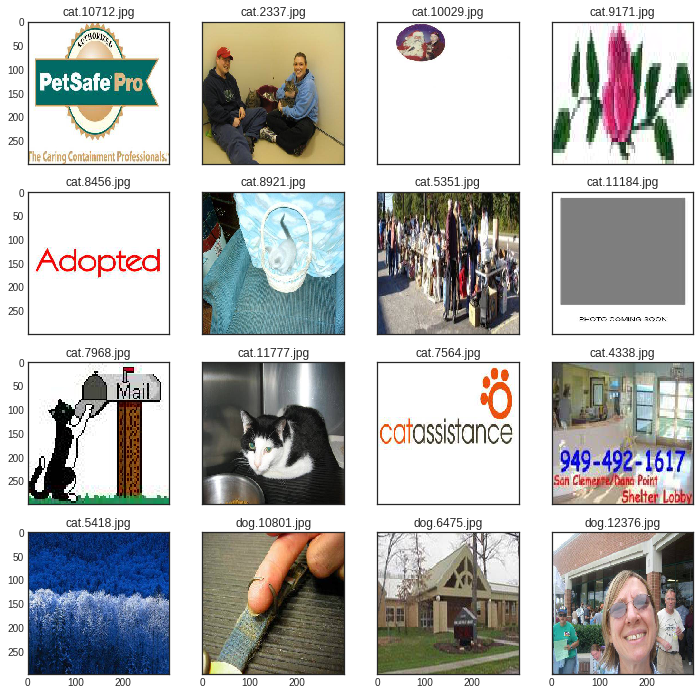

/home/mj/.conda/envs/ten/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [74]:
def show_pic(fp):
    img = cv2.imread('imgs/train/%s' % fp)
    plt.imshow(img)
    plt.axis('on')
    plt.title(fp)
    plt.show()
# 获取能match到猫狗类型的预测总数
def get_right_list(pred):
    right_list = []
    for item in pred:
        pred_list = [ x[0] for x in item ]
        pred_list = [ 1 for x in pred_list if x in imageNet_class ]
        right_list.append(sum(pred_list))
    return(right_list)

# 获取异常数据的文件名
right_list = get_right_list(pred)
exp_flist = []
for index, value in enumerate(right_list):
    if value == 0:
        exp_flist.append(train_total[index])
        

plt.style.use('seaborn-white')
random.seed(42)
#查看图片内容
fig,ax = plt.subplots(4,4,sharex='col',sharey='row',figsize=(12,12))

print (len(exp_flist))
index = 0
for i in range(4):
    for j in range(4):
        img = image.load_img("imgs/train/%s" % exp_flist[index],target_size=img_size)
        ax[i,j].set_title('%s'% exp_flist[index])
        ax[i,j].imshow(img)
        index+=1

In [5]:
def build_mkdir(dirname):
    if os.path.exists(dirname):
        #delete old direct
        shutil.rmtree(dirname)
    os.mkdir(dirname)

build_mkdir('imgs/train2')
os.mkdir('imgs/train2/cat')
os.mkdir('imgs/train2/dog')

#copy files to new path
def copy_to_newPath(oldPath:str,newPath:str,imgName:list)->None:
    for img in imgName:
        pathA = oldPath + img
        pathB = newPath + img
        shutil.copyfile(pathA,pathB)
        
copy_to_newPath('imgs/train/','imgs/train2/cat/',train_cat)
copy_to_newPath('imgs/train/','imgs/train2/dog/',train_dog)


## 加载数据集
猫狗大战数据集：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [6]:
train_path = "imgs/train2"
test_path = "imgs/test2"

gen = ImageDataGenerator()
X_train_gen = gen.flow_from_directory(train_path, img_size, shuffle = False, 
                                        batch_size = 16)
X_test_gen = gen.flow_from_directory(test_path, img_size, shuffle = False, 
                                        batch_size = 16, classes = None)

Found 24997 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


## 构建模型

In [7]:
#基础模型
input_tensor = Input((img_size[0], img_size[1], 3))
input_tensor = Lambda(inception_v3.preprocess_input)(input_tensor)
base_model = InceptionV3(input_tensor = input_tensor, 
                             weights = 'imagenet', include_top = False)
base_model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

## 训练特征向量

In [8]:
X_train = base_model.predict_generator(X_train_gen, verbose=1)
X_test = base_model.predict_generator(X_test_gen, verbose=1)

782/782 [==============================] - 62s 80ms/step


## 保存特征的权重

In [10]:
with h5py.File('saved_models/weights.inv3.hdf5') as fp:
        fp.create_dataset('train', data = X_train)
        fp.create_dataset('test', data = X_test)
        fp.create_dataset('label', data = X_train_gen.classes)

## 导入保存的权重

In [11]:
X_train = []
X_test = []
with h5py.File('saved_models/weights.inv3.hdf5', 'r') as fp:
    X_train.append(np.array(fp['train']))
    X_test.append(np.array(fp['test']))
    y_train = np.array(fp['label'])
    
X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)
X_train, y_train = shuffle(X_train, y_train)

## 增加全连接层和dropout层

In [12]:
input_tensor = Input(X_train.shape[1:])
inception_v3_model = Model(input_tensor, Dropout(0.5)(input_tensor))
inception_v3_model = Model(inception_v3_model.input, Dense(1, activation = 'sigmoid')(inception_v3_model.output))
inception_v3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


## 编译模型

In [13]:
inception_v3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 训练模型

In [16]:
epochs = 10
batch_size = 128
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inv3.hdf5', 
                                   verbose=1, save_best_only=True)
history_tarin = inception_v3_model.fit(X_train, y_train, validation_split = 0.2,
                    epochs = epochs, batch_size = batch_size, verbose=1,
                    callbacks=[checkpointer])

Train on 19997 samples, validate on 5000 samples
Epoch 1/10
19997/19997 [==============================] - 1s 47us/step - loss: 0.1549 - acc: 0.9505 - val_loss: 0.0458 - val_acc: 0.9904

Epoch 00001: val_loss improved from inf to 0.04581, saving model to saved_models/weights.best.inv3.hdf5
Epoch 2/10
19997/19997 [==============================] - 0s 16us/step - loss: 0.0431 - acc: 0.9899 - val_loss: 0.0313 - val_acc: 0.9920

Epoch 00002: val_loss improved from 0.04581 to 0.03126, saving model to saved_models/weights.best.inv3.hdf5
Epoch 3/10
19997/19997 [==============================] - 0s 22us/step - loss: 0.0324 - acc: 0.9917 - val_loss: 0.0262 - val_acc: 0.9918

Epoch 00003: val_loss improved from 0.03126 to 0.02616, saving model to saved_models/weights.best.inv3.hdf5
Epoch 4/10
19997/19997 [==============================] - 0s 22us/step - loss: 0.0280 - acc: 0.9921 - val_loss: 0.0236 - val_acc: 0.9924

Epoch 00004: val_loss improved from 0.02616 to 0.02357, saving model to saved_m

## 预测测试集

In [17]:
y_pred = inception_v3_model.predict(X_test)
y_pred = y_pred.clip(min = 0.005, max = 0.995)

In [18]:
num = [ int(re.sub('.jpg', '', re.sub('.*\/', '', f))) for f in X_test_gen.filenames ]
df = pd.read_csv("sample_submission.csv")
for i in range(len(num)):
    df.set_value(num[i] - 1, 'label', y_pred[i])
df.to_csv('pred.csv', index=None)
df.head(10)

/home/mj/.conda/envs/ten/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005